In [1]:
# =========================
# Cell 1: Load the model (download from S3, then tf load_model)
# =========================
import os
import boto3
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Starting: Downloading model from S3...")

MODEL_S3_URI = "s3://ai-bmi-predictor-v2/tight and loose classifier/trained models/clothes_classifier_mobilenetv2.h5"
LOCAL_DIR = "./artifacts"
os.makedirs(LOCAL_DIR, exist_ok=True)
LOCAL_MODEL_PATH = os.path.join(LOCAL_DIR, "clothes_classifier_mobilenetv2.h5")

def parse_s3_uri(s3_uri: str):
    assert s3_uri.startswith("s3://"), "S3 URI must start with s3://"
    without = s3_uri[5:]
    bucket, key = without.split("/", 1)
    return bucket, key

bucket, key = parse_s3_uri(MODEL_S3_URI)
s3 = boto3.client("s3")

print(f"Model bucket: {bucket}")
print(f"Model key: {key}")
print(f"Downloading to: {LOCAL_MODEL_PATH}")

s3.download_file(bucket, key, LOCAL_MODEL_PATH)
print("✅ Model downloaded.")

print("Loading model with tf.keras.models.load_model(...)")
# compile=False is safer when you don't need training-time objects
model = tf.keras.models.load_model(LOCAL_MODEL_PATH, compile=False)
print("✅ Model loaded.")


2025-12-23 15:19:41.640707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 15:19:41.656452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-23 15:19:41.681114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-23 15:19:41.681146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-23 15:19:41.696116: I tensorflow/core/platform/cpu_feature_gua

TensorFlow version: 2.16.2
Starting: Downloading model from S3...
Model bucket: ai-bmi-predictor-v2
Model key: tight and loose classifier/trained models/clothes_classifier_mobilenetv2.h5
✅ Model downloaded.
Loading model with tf.keras.models.load_model(...)


2025-12-23 15:19:44.017057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-23 15:19:44.063062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-23 15:19:44.064159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

✅ Model loaded.


In [2]:
# =========================
# Cell 2: Model summary
# =========================
print("Printing model summary...\n")
model.summary()

print("\nModel output shape:", model.output_shape)
print("✅ Summary done.")


Printing model summary...

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0        

In [3]:
# =========================
# Cell 3: Load dataset for inferencing (download Testing Data from S3, then load from directory)
# =========================
import math
from pathlib import Path

print("Starting: Downloading Testing Data/ from S3...")

# IMPORTANT: set this to your Testing Data prefix in S3
# Based on your screenshot path, it looks like:
# s3://ai-bmi-predictor-v2/tight and loose classifier/orginal dataset/Dataset/Testing Data/
TEST_S3_PREFIX = "tight and loose classifier/orginal dataset/Dataset/Testing Data/"

LOCAL_TEST_DIR = os.path.join(LOCAL_DIR, "Testing_Data")
os.makedirs(LOCAL_TEST_DIR, exist_ok=True)

print("Test bucket:", bucket)
print("Test prefix:", TEST_S3_PREFIX)
print("Local test dir:", LOCAL_TEST_DIR)

paginator = s3.get_paginator("list_objects_v2")
pages = paginator.paginate(Bucket=bucket, Prefix=TEST_S3_PREFIX)

downloaded = 0
for page in pages:
    contents = page.get("Contents", [])
    for obj in contents:
        k = obj["Key"]
        if k.endswith("/"):
            continue  # folder marker
        rel_path = k[len(TEST_S3_PREFIX):]  # path under Testing Data/
        local_path = os.path.join(LOCAL_TEST_DIR, rel_path)
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        s3.download_file(bucket, k, local_path)
        downloaded += 1

print(f"✅ Download complete. Files downloaded: {downloaded}")

print("\nLoading dataset from local directory...")
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    LOCAL_TEST_DIR,
    labels="inferred",
    label_mode="int",      # gives 0/1 as ints
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False          # IMPORTANT for correct confusion matrix ordering
)

class_names = test_ds_raw.class_names
print("✅ Dataset loaded.")
print("Detected class names (alphabetical):", class_names)
print("Expected indices: {'Loose': 0, 'Tight': 1}")


Starting: Downloading Testing Data/ from S3...
Test bucket: ai-bmi-predictor-v2
Test prefix: tight and loose classifier/orginal dataset/Dataset/Testing Data/
Local test dir: ./artifacts/Testing_Data
✅ Download complete. Files downloaded: 21

Loading dataset from local directory...
Found 21 files belonging to 2 classes.
✅ Dataset loaded.
Detected class names (alphabetical): ['Loose', 'Tight']
Expected indices: {'Loose': 0, 'Tight': 1}


In [4]:
# =========================
# Cell 4: Data preprocessing (rescale = 1/255 like training)
# =========================
AUTOTUNE = tf.data.AUTOTUNE

print("Starting preprocessing: applying rescale=1/255 and performance options...")

rescale_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

def preprocess_batch(images, labels):
    images = tf.cast(images, tf.float32)
    images = rescale_layer(images)
    return images, labels

test_ds = test_ds_raw.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

print("✅ Preprocessing pipeline ready.")


Starting preprocessing: applying rescale=1/255 and performance options...
✅ Preprocessing pipeline ready.


In [5]:
# =========================
# Cell 5: Evaluation (model.evaluate)
# =========================
print("Starting evaluation...")

# Decide loss based on output shape (sigmoid vs softmax)
out_shape = model.output_shape
last_dim = out_shape[-1] if isinstance(out_shape, (tuple, list)) else None

if last_dim == 1:
    print("Detected binary output (last_dim=1). Using BinaryCrossentropy.")
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    metric_list = [tf.keras.metrics.BinaryAccuracy(name="accuracy")]
    
    # For binary output, labels should be float32 shape (batch, 1)
    def to_binary_label_shape(x, y):
        y = tf.cast(y, tf.float32)
        y = tf.expand_dims(y, axis=-1)
        return x, y
    
    test_ds_eval = test_ds.map(to_binary_label_shape, num_parallel_calls=AUTOTUNE)
    model.compile(optimizer="adam", loss=loss_fn, metrics=metric_list)
    results = model.evaluate(test_ds_eval, verbose=1)

else:
    print("Detected multi-class output. Using SparseCategoricalCrossentropy.")
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    metric_list = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    model.compile(optimizer="adam", loss=loss_fn, metrics=metric_list)
    results = model.evaluate(test_ds, verbose=1)

print("✅ Evaluation done.")
print("Metrics:", dict(zip(model.metrics_names, results)))


Starting evaluation...
Detected binary output (last_dim=1). Using BinaryCrossentropy.


2025-12-23 15:20:59.510812: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 [==============================] - 15s 15s/step - loss: 0.6311 - accuracy: 0.9524
✅ Evaluation done.
Metrics: {'loss': 0.6311438083648682, 'accuracy': 0.9523809552192688}


Starting: generating predictions + confusion matrix...


2025-12-23 15:21:13.344751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 [==============================] - 4s 4s/step
✅ Confusion matrix computed.
Confusion Matrix (rows=true, cols=pred):
 [[10  1]
 [ 0 10]]


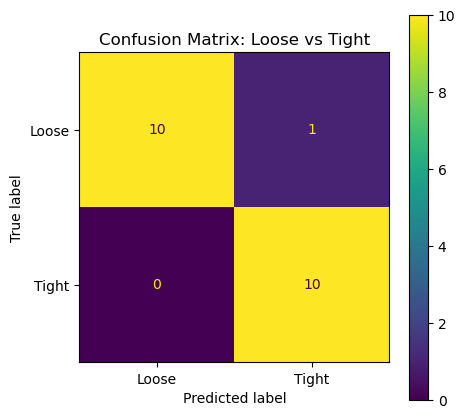

In [6]:
# =========================
# Cell 6: Plot confusion matrix
# =========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Starting: generating predictions + confusion matrix...")

# Collect y_true
y_true = np.concatenate([y.numpy() for _, y in test_ds_raw], axis=0)

# Predict probabilities/logits
y_pred_raw = model.predict(test_ds, verbose=1)

# Convert predictions to class indices 0/1
if (isinstance(y_pred_raw, np.ndarray) and y_pred_raw.ndim == 2 and y_pred_raw.shape[1] == 1):
    # sigmoid style: shape (N,1)
    y_prob_tight = y_pred_raw[:, 0]
    y_pred = (y_prob_tight >= 0.5).astype(int)
else:
    # softmax style: shape (N,2)
    y_pred = np.argmax(y_pred_raw, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

print("✅ Confusion matrix computed.")
print("Confusion Matrix (rows=true, cols=pred):\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loose", "Tight"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, values_format="d")
plt.title("Confusion Matrix: Loose vs Tight")
plt.show()


In [7]:
# =========================
# Cell 7: Calculate accuracy, precision, recall, F1 via confusion matrix
# =========================
print("Starting: computing metrics from confusion matrix...")

# With labels [0=Loose, 1=Tight]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
tp = cm[1, 1]

accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0.0
precision = tp / (tp + fp) if (tp + fp) else 0.0          # for positive class = Tight
recall = tp / (tp + fn) if (tp + fn) else 0.0             # for positive class = Tight
f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

print("✅ Metrics computed (positive class = 'Tight').")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


Starting: computing metrics from confusion matrix...
✅ Metrics computed (positive class = 'Tight').
TN=10, FP=1, FN=0, TP=10
Accuracy : 0.9524
Precision: 0.9091
Recall   : 1.0000
F1-score : 0.9524
